# Conditional generative transformer: MNIST demo

Based off https://github.com/GregorKobsik/ImageTransformer

- mnist dataset
    - quantize to 8 values
    - random masking
- model
    - attention mask so that each pixel doesn't get itself as input?
    - predict output distribution for particular pixel
- training
    - learning rate schedule

In [1]:
model_name = input()
print()
new_kernel = True

use_wandb = True
if use_wandb:
    import wandb
    wandb_id = wandb.util.generate_id()

 reserve-gpu-1


In [2]:
config = {
    'minibatch_size': 128,
    'test_minibatch_size': 10,
    'n_colors': 2,
    'model': {
        'n_enc_a_layers': 8,
        'ffl_dim': 200,
        'embd_dim': 128,
        'n_heads': 4,
        'dropout_rate': 0.1,
        'use_idxs_input': True,
    },
    'dataset': {
        'buffer_size': 10000,
    },
    'lr_schedule': 'exponential',
    'lr_warmup_steps': 300,
    'max_lr': 0.004,
    'min_lr': 0.000001,
    'batch_size_schedule': None,
    'start_accum_steps': 1,
    'end_accum_steps': 4,
    'steps_per_epoch': 300,
    'n_epochs': 400,
    'seq_length': 784,
    'wandb_log_interval': 10,
}

In [3]:
if use_wandb:
    resume = not new_kernel
    wandb.init(project='cgt-mnist', entity='maxeonyx', name=model_name + '-' + wandb_id, config=config, resume=resume)

wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
/am/monterey/home1/clarkemaxw/.cache/pypoetry/virtualenvs/msc-4QRxScII-py3.8/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import tensorflow as tf
# https://stackoverflow.com/a/60699372/7989988
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp

2021-11-12 13:33:28.337125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-12 13:33:28.845712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22360 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6
2021-11-12 13:33:28.916802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-12 13:33:28.952062: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents o

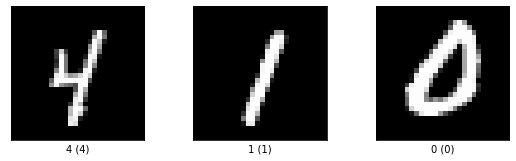

2021-11-12 13:33:29.203336: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


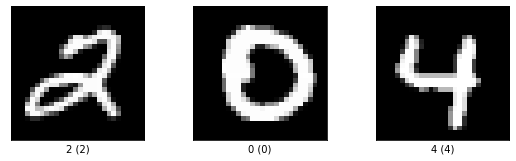

In [5]:
dataset, metadata = tfds.load('mnist', with_info=True, as_supervised=True)

dataset_train_original = dataset['train']
dataset_test_original = dataset['test']

image_width=28
image_height=28

fig = tfds.show_examples(dataset_train_original.take(3), metadata)
fig = tfds.show_examples(dataset_test_original.take(3), metadata)

In [21]:
from sklearn.cluster import MiniBatchKMeans

def normalize_image(image, label):
    return tf.cast(image, dtype=tf.float16) / 255.0, label

def find_centroids(ds_train, num_clusters, batch_size):
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=batch_size, verbose=True)
    ds_batched = ds_train.batch(batch_size)
    with enlighten.get_manager() as manager:
        title = manager.status_bar(f"K-Means clustering to make {num_clusters}-color MNIST Dataset", justify=enlighten.Justify.CENTER)
        clusters_names = manager.status_bar(''.join('{:<10}'.format(f"cen. {i}") for i in range(num_clusters)))
        clusters_status = manager.status_bar(''.join('{:<10}'.format('??????') for _ in range(num_clusters)))
        pbar = manager.counter(total=60000//batch_size, desc='Discretize to 8 colors', unit='minibatches')
        for img, _ in pbar(iter(ds_batched)):
            pixels = img.numpy().reshape(-1, 1)
            kmeans.partial_fit(pixels)
            clusters_status.update(''.join('{:<10.3f}'.format(x[0]) for x in np.sort(kmeans.cluster_centers_, axis=0)))

        return kmeans.cluster_centers_

centroids = find_centroids(dataset_train_original.map(normalize_image), num_clusters=config['n_colors'], batch_size=1000)
centroids = tf.convert_to_tensor(np.sort(centroids, axis=0), dtype=tf.float16)
print(centroids.shape)

(2, 1)


tf.Tensor(
[ 19 153  38 594 397 141 256 145  60  92 293 196 370 116  60  35 106 474
  67  93 324 372  13  41 234  29  69 121  68   6 147 300 146  49 217  72
 103 117  35 130 213  66 322  43  59 207  79  12  40  29 538  87   4  14
 332 136  19 152 219  52  26  83 248 156 231  63 161 293  51 237 141 137
 594 144 123  89 125  77 279 528  80 127 134 274 183 260 115  34 159  61
  31 280  62 148 550  98 195 151 232 158], shape=(100,), dtype=int32)


/tmp/ipykernel_6124/2074296751.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_6124/2074296751.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


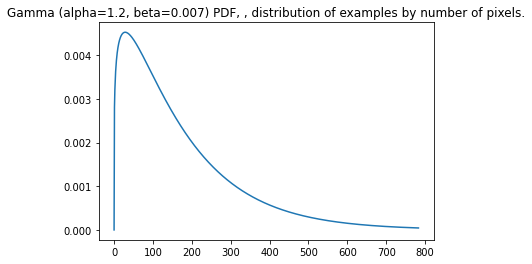

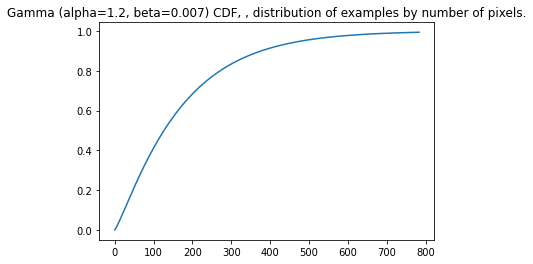

In [22]:

gamma = tfp.distributions.Gamma(concentration=1.2, rate=0.007)

def plot_cdf(dist, name):
    x = tf.range(784, dtype=tf.float32)
    cdf = dist.cdf(x)
    fig, ax = plt.subplots()
    ax.plot(tf.range(784), cdf)
    ax.set_title(f"{name} CDF, , distribution of examples by number of pixels.")
    fig.show()

def plot_pdf(dist, name):
    x = tf.range(784, dtype=tf.float32)
    pdf = dist.prob(x)
    fig, ax = plt.subplots()
    ax.plot(tf.range(784), pdf)
    ax.set_title(f"{name} PDF, , distribution of examples by number of pixels.")
    fig.show()

def test_sample(dist):
    
    return tf.cast(tf.math.minimum(tf.math.round(dist.sample(sample_shape=[100])), 783), tf.int32)

plot_pdf(gamma, "Gamma (alpha=1.2, beta=0.007)")
plot_cdf(gamma, "Gamma (alpha=1.2, beta=0.007)")
print(test_sample(gamma))

In [23]:
def squared_euclidean_distance(a, b):
    b = tf.transpose(b)        
    a2 = tf.math.reduce_sum(tf.math.square(a), axis=1, keepdims=True)
    b2 = tf.math.reduce_sum(tf.math.square(b), axis=0, keepdims=True)
    ab = tf.linalg.matmul(a, b)
    return a2 - 2 * ab + b2

def flatten(image, label):
    shape = tf.shape(image) # (height, width, color)
    sequence = tf.reshape(image, (-1, shape[2])) # (height * width, color)
    return sequence, label

def quantize(sequence, label):
    d = squared_euclidean_distance(sequence, centroids) # (height * width, centroids)
    sequence = tf.math.argmin(d, axis=1, output_type=tf.int32)  # (height * width)
    return sequence, label

def unquantize(x):
    x_one_hot = tf.cast(tf.one_hot(x, depth=len(centroids)), dtype=tf.float16)  # (seq, num_centroids)
    return tf.linalg.matmul(x_one_hot,centroids)  # (seq, num_features)

def shuffle_and_add_indices(sequence, label):
    
    idxs = tf.range(config['seq_length'], dtype=tf.int32)
    idxs = tf.random.shuffle(idxs)
    
    sequence = tf.gather(sequence, idxs)
    
    return sequence, idxs, label


def add_n_from_distribution(dist):
    
    def call(batch_sequences, batch_idxs, batch_labels):
        # sample single integer between 0 and 783 from given distribution
        n = tf.cast(tf.math.minimum(tf.math.round(dist.sample(sample_shape=[])), config['seq_length'] - 1), tf.int32)
    
        return batch_sequences, batch_idxs, batch_labels, n
    
    return call

def add_indices(sequence, label):
    
    idxs = tf.range(config['seq_length'], dtype=tf.int32)
    
    return sequence, idxs, label

dataset_train = (
    dataset_train_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .map(shuffle_and_add_indices)
    .cache()
    .repeat()
    .shuffle(config['dataset']['buffer_size'])
    .batch(config['minibatch_size'], drop_remainder=True)
    # split input and target according to gamma distribution shown above
    .map(add_n_from_distribution(gamma))
    .prefetch(tf.data.experimental.AUTOTUNE)
)
dataset_test = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .map(add_indices)
    .cache()
    .batch(config['test_minibatch_size'], drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
dataset_test_shuffled = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .map(shuffle_and_add_indices)
    .cache()
    .batch(config['test_minibatch_size'], drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

quantized:


2021-11-11 15:26:27.324553: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


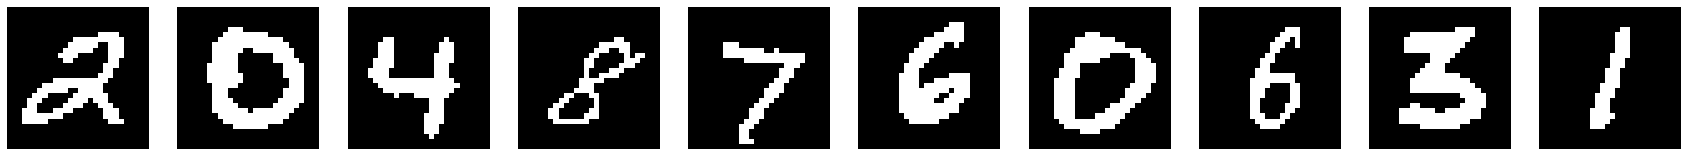

unquantized:


2021-11-11 15:26:27.754187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


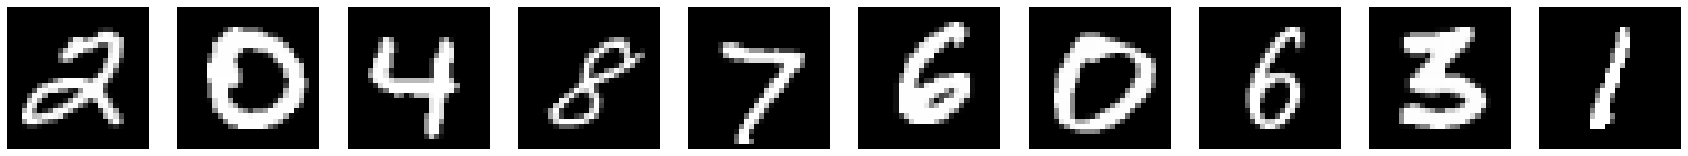

shuffled:


2021-11-11 15:26:28.134862: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


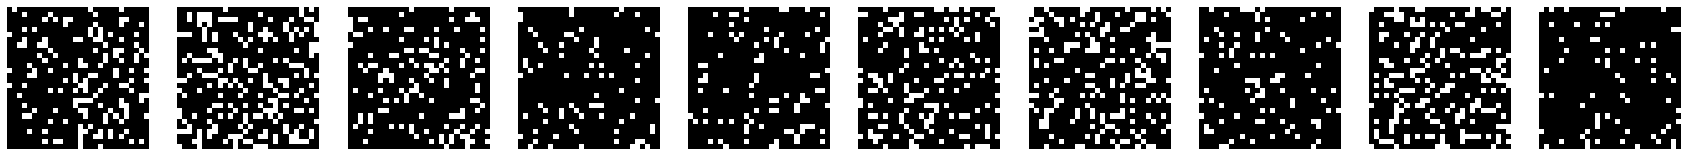

unshuffled:


2021-11-11 15:26:28.868049: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


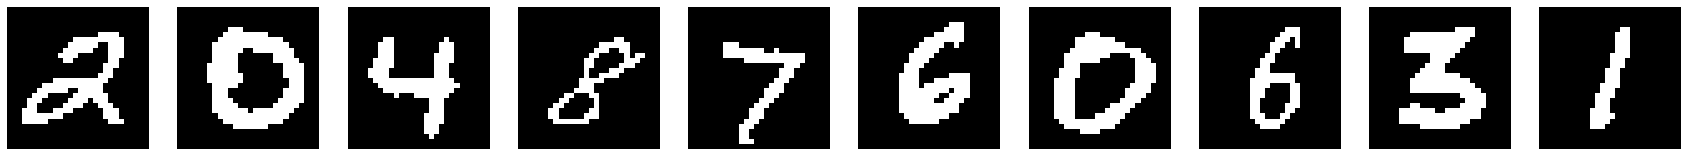

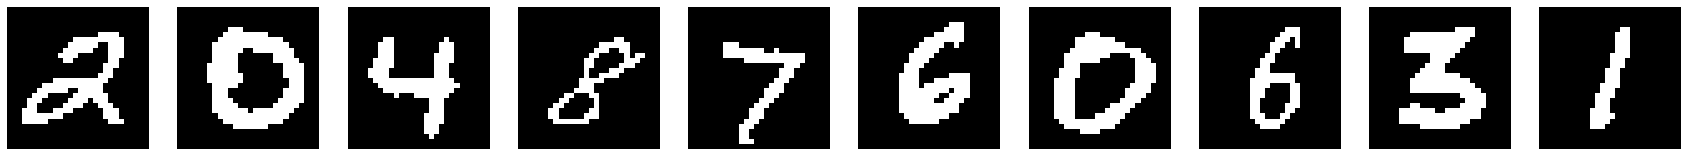

In [24]:
def np_showSeq(seq, size, max_images=3, cmap=None):
    """ Show one or more images encoded as sequence. (numpy version)

        seq: numpy array of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """ 
    batch = seq.shape[0]
    num_show_img = min(max_images, seq.shape[0])
    img = np.reshape(seq, (batch, *size, -1))
    if img.shape[-1] == 1:
        img = np.squeeze(img, axis=-1)    
    
    fig=plt.figure(figsize=(3*num_show_img, 3))
    for i in range(num_show_img):
        ax = fig.add_subplot(1, num_show_img, i+1)
        ax.set_axis_off()
        plt.imshow(img[i], cmap=cmap)
    plt.show()
    return fig

def showSeq(seq, idxs, size, max_images=3, cmap='gray', unshuffle=False, do_unquantize=True):
    """ Show one or more images encoded as sequence. (tensorflow version)

        seq: tensor of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """
    batch_size = idxs.shape[0]
    seq_length = idxs.shape[1]
    img_length = size[0]*size[1]
    if unshuffle:
        batch_idxs = tf.tile(tf.expand_dims(tf.range(batch_size), -1), [1, seq_length])
        idxs_nd = tf.concat([tf.expand_dims(batch_idxs, -1), tf.expand_dims(idxs, -1)], axis=-1)
        seq = tf.scatter_nd(idxs_nd, seq, [batch_size, img_length])
    
    if do_unquantize:
        seq = tf.map_fn(fn=unquantize, elems=seq, fn_output_signature=tf.float16)
    seq = tf.cast(seq, float).numpy()

    return np_showSeq(seq, size, max_images, cmap)


NUM_SAMPLES = 10

ds_test_unquantized = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .map(add_indices)
    .batch(NUM_SAMPLES)
)
ds_test_quantized = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .map(add_indices)
    .batch(NUM_SAMPLES)
)
ds_test_shuffled = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .map(shuffle_and_add_indices)
    .batch(NUM_SAMPLES)
)
print("quantized:")
ex, ex_idxs, _ = next(iter(ds_test_quantized))
showSeq(ex, ex_idxs, (image_width, image_height), NUM_SAMPLES, unshuffle=False)
print("unquantized:")
ex, ex_idxs, _ = next(iter(ds_test_unquantized))
showSeq(ex, ex_idxs, (image_width, image_height), NUM_SAMPLES, unshuffle=False, do_unquantize=False)
print("shuffled:")
ex, ex_idxs, _ = next(iter(ds_test_shuffled))
showSeq(ex, ex_idxs, (image_width, image_height), NUM_SAMPLES, unshuffle=False)
print("unshuffled:")
ex, ex_idxs, _ = next(iter(ds_test_shuffled))
showSeq(ex, ex_idxs, (image_width, image_height), NUM_SAMPLES, unshuffle=True)

In [25]:
def create_look_backward_equal_mask(size_q, size_k):
    mask = 1 - tf.linalg.band_part(tf.ones((size_q, size_k)), -1, 0)
    return mask  # (size_q, size_k)

def create_look_backward_mask(size_q, size_k):
    mask = tf.linalg.band_part(tf.ones((size_q, size_k)), 0, -1)
    return mask  # (size_q, size_k)

def create_look_forward_mask(size_q, size_k):
    return tf.transpose(create_look_backward_mask(size_k, size_q))

def create_look_forward_equal_mask(size_q, size_k):
    return tf.transpose(create_look_backward_equal_mask(size_k, size_q))

# No masking. Use for evaluation when input and target have no overlap
MASK_NONE = tf.constant(0, dtype=tf.int32)
# Normal masking, each token only has access to previous tokens
MASK_BACKWARD = tf.constant(1, dtype=tf.int32)
# Use for non-offset self-attention, token has access to previous *and* itself
MASK_BACKWARD_EQUAL = tf.constant(2, dtype=tf.int32)
# Use inside target idx encoder
MASK_FORWARD = tf.constant(3, dtype=tf.int32)
# Use inside target idx encoder
MASK_FORWARD_EQUAL = tf.constant(4, dtype=tf.int32)

@tf.function
def get_mask(mask_type, seq_len_kv, seq_len_q):
    if mask_type == MASK_BACKWARD:
        return create_look_backward_mask(seq_len_q, seq_len_kv)
    elif mask_type == MASK_BACKWARD_EQUAL:
        return create_look_backward_equal_mask(seq_len_q, seq_len_kv)
    elif mask_type == MASK_FORWARD:
        return create_look_forward_mask(seq_len_q, seq_len_kv)
    elif mask_type == MASK_FORWARD_EQUAL:
        return create_look_forward_equal_mask(seq_len_q, seq_len_kv)
    else:
        return tf.zeros((seq_len_q, seq_len_kv))

print("backward")
print(create_look_backward_mask(7,7))
print()
print("backward_equal")
print(create_look_backward_equal_mask(7,7))
print()
print("forward")
print(create_look_forward_mask(7,7))
print()
print("forward_equal")
print(create_look_forward_equal_mask(7,7))
print()

backward
tf.Tensor(
[[1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1.]], shape=(7, 7), dtype=float32)

backward_equal
tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]], shape=(7, 7), dtype=float32)

forward
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1.]], shape=(7, 7), dtype=float32)

forward_equal
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0.]], shape=(7, 7), dtype=float32)



In [26]:


# scale is the max-min of vals
# for mnist it's 28 because thats the width and height of the images
def dual_positional_encoding(n_dims, length):
    one_axis_dim = n_dims//2
    i = tf.range(n_dims//4, dtype=tf.float32)
    i = tf.expand_dims(i, -2)
    scale = tf.pow(length, 2.*i/one_axis_dim)
    
    def pos_enc(vals):
        vals = tf.expand_dims(vals, -1)

        # the bit inside the sin / cos
        rate = vals / scale
        sin = tf.sin(rate)
        cos = tf.cos(rate)
        encoding = tf.concat([sin, cos], axis=-1)
        return encoding
    
    def call(idxs):
        rows = idxs // 28
        cols = idxs % 28
        
        row_enc = pos_enc(rows)
        col_enc = pos_enc(cols)
        
        encoding = tf.concat([row_enc, col_enc], axis=-1)
        return encoding
        
    return call


def scaled_dot_product_attention(k, q, v, mask):
    batch_size = tf.shape(k)[0]
    seq_len_kv = tf.shape(k)[-2]
    kq_dim = tf.shape(k)[-1]
    seq_len_q = tf.shape(q)[-2]
    v_dim = tf.shape(v)[-1]
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # shape: (batch_size, n_heads, seq_len_q, seq_len_kv)
    
    dk = tf.cast(kq_dim, tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    scaled_attention_logits += mask * -1e9 # batch dim broadcast
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # sums to 1 along last axis
    # shape: (batch_size, seq_len_q, seq_len_kv)
    
    output = tf.matmul(attention_weights, v)
    # shape: (batch_size, seq_len_q, v_dim)
    
    return output, attention_weights

def multi_head_attention(embd_dim, n_heads):
    
    wk = layers.Dense(embd_dim)
    wq = layers.Dense(embd_dim)
    wv = layers.Dense(embd_dim)
    dense = layers.Dense(embd_dim)
    
    assert embd_dim % n_heads == 0, "embd_dim must divide evenly into n_heads"
    head_width = embd_dim//n_heads
    
    def split_heads(x, batch_size):
        # reshape from (batch_size, seq_length, embd_dim) to (batch_size, num_heads, seq_len, head_width)
        x = tf.reshape(x, (batch_size, -1, n_heads, head_width))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(k, q, v, mask):
        batch_size = tf.shape(k)[0]
        
        k = wk(k)
        q = wk(q)
        v = wk(v)
        # shape: (batch_size, seq_len_*, embd_dim)
        
        k = split_heads(k, batch_size)
        q = split_heads(q, batch_size)
        v = split_heads(v, batch_size)
        # shape: (batch_size, num_heads, seq_len_*, head_width)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(k, q, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # (batch_size, seq_len, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, embd_dim))
        output = dense(concat_attention)
        return output, attention_weights
    return call
    
def pointwise_feedforward_layer(hidden_dim, out_dim):
    dense1 = layers.Dense(hidden_dim, activation='relu')
    dense2 = layers.Dense(out_dim)
    def call(x):
        x = dense1(x)
        x = dense2(x)
        return x
    return call
        

def transformer(n_colors, seq_length, embd_dim, ffl_dim, n_heads, n_enc_a_layers, dropout_rate, use_idxs_input):
    def transformer_layer():
        mha = multi_head_attention(embd_dim, n_heads)
        ffl = pointwise_feedforward_layer(ffl_dim, embd_dim)
        layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        dropout1 = layers.Dropout(dropout_rate)
        dropout2 = layers.Dropout(dropout_rate)
        def call(kv_embd, q_embd, mask):
            x = q_embd
            out1 = layernorm1(dropout1(kv_embd)) # prenorm
            attn_out, attn_weights = mha(out1, q_embd, out1, mask)
            x += attn_out
            
            out2 = layernorm2(dropout2(x)) # prenorm
            ffl_out = ffl(out2)
            x += ffl_out
            
            return x
        return call
    
    def transformer_3sep_layer():
        mha = multi_head_attention(embd_dim, n_heads)
        ffl = pointwise_feedforward_layer(ffl_dim, embd_dim)
        layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        dropout1 = layers.Dropout(dropout_rate)
        dropout2 = layers.Dropout(dropout_rate)
        def call(key, query, val, mask):
            key = layernorm1(dropout1(key)) # prenorm
            val = layernorm1(dropout1(val)) # prenorm
            attn_out, attn_weights = mha(key, query, val, mask)
            x = query + attn_out
            
            out2 = layernorm2(dropout2(x)) # prenorm
            ffl_out = ffl(out2)
            x += ffl_out
            
            return x
        return call
    
    # attentive neural process
    def anp_architecture():
        enc_a_layers = [transformer_layer() for _ in range(n_enc_a_layers)]
        dec_layer = transformer_3sep_layer()
        x_encoder = pointwise_feedforward_layer(ffl_dim, embd_dim)
        def call(inp_xy, inp_x, tar_x, enc_a_mask, dec_mask):
            inp_x = x_encoder(inp_x)
            tar_x = x_encoder(tar_x)
            for enc_layer in enc_a_layers:
                inp_xy += enc_layer(inp_xy, inp_xy, mask=enc_a_mask)
            outs = dec_layer(key=inp_x, query=tar_x, val=inp_xy, mask=dec_mask)
            return outs
        return call
    
    # custom attentive neural process
    def canp_architecture():
        enc_a_layers = [transformer_layer() for _ in range(n_enc_a_layers)]
        dec_layer = transformer_layer()
        def call(xa, xb, enc_a_mask, dec_mask):
            for enc_layer in enc_a_layers:
                xa += enc_layer(xa, xa, mask=enc_a_mask)
            outs = dec_layer(xa, xb, mask=dec_mask)
            return outs
        return call
    
    colors = Input([None])
    inp_idxs = Input([None])
    tar_idxs = Input([None])
    # use type_spec argument because we don't want batch dim for these inputs
    enc_a_mask = Input(type_spec=tf.TensorSpec(shape=[None, None]))
    dec_mask = Input(type_spec=tf.TensorSpec(shape=[None, None]))
    
    col_embd = layers.Embedding(n_colors, embd_dim)(colors)
    # set length to somewhat bigger than the image width/height
    position_embedding = dual_positional_encoding(n_dims=embd_dim, length=100)
    
    inp_pos_embd = position_embedding(inp_idxs)
    tar_pos_embd = position_embedding(tar_idxs)
    
    dropout = layers.Dropout(dropout_rate)
    layer_norm = layers.LayerNormalization(epsilon=1e-6)
    
    xa = col_embd + inp_pos_embd
    xb = tar_pos_embd
    
    y = anp_architecture()(xa, inp_pos_embd, tar_pos_embd,  enc_a_mask, dec_mask)
    
    y = layer_norm(dropout(y))
    
    final_layer = layers.Dense(n_colors)(y)
    
    return Model(inputs=[colors, inp_idxs, tar_idxs, enc_a_mask, dec_mask], outputs=[final_layer])



In [27]:

model = transformer(
    config['n_colors'],
    seq_length=783,
    **config['model'],
)
print('Model Config')
print(', '.join(f'{k}: {v}' for k, v in config['model'].items()))
print()

# model.summary()

# from tf.keras.utils.vis_utils import plot_model

# plot_model(model, to_file="model.png", expand_nested=True, show_shapes=True, show_layer_names=True)


Model Config
n_enc_a_layers: 8, ffl_dim: 200, embd_dim: 128, n_heads: 4, dropout_rate: 0.1, use_idxs_input: True



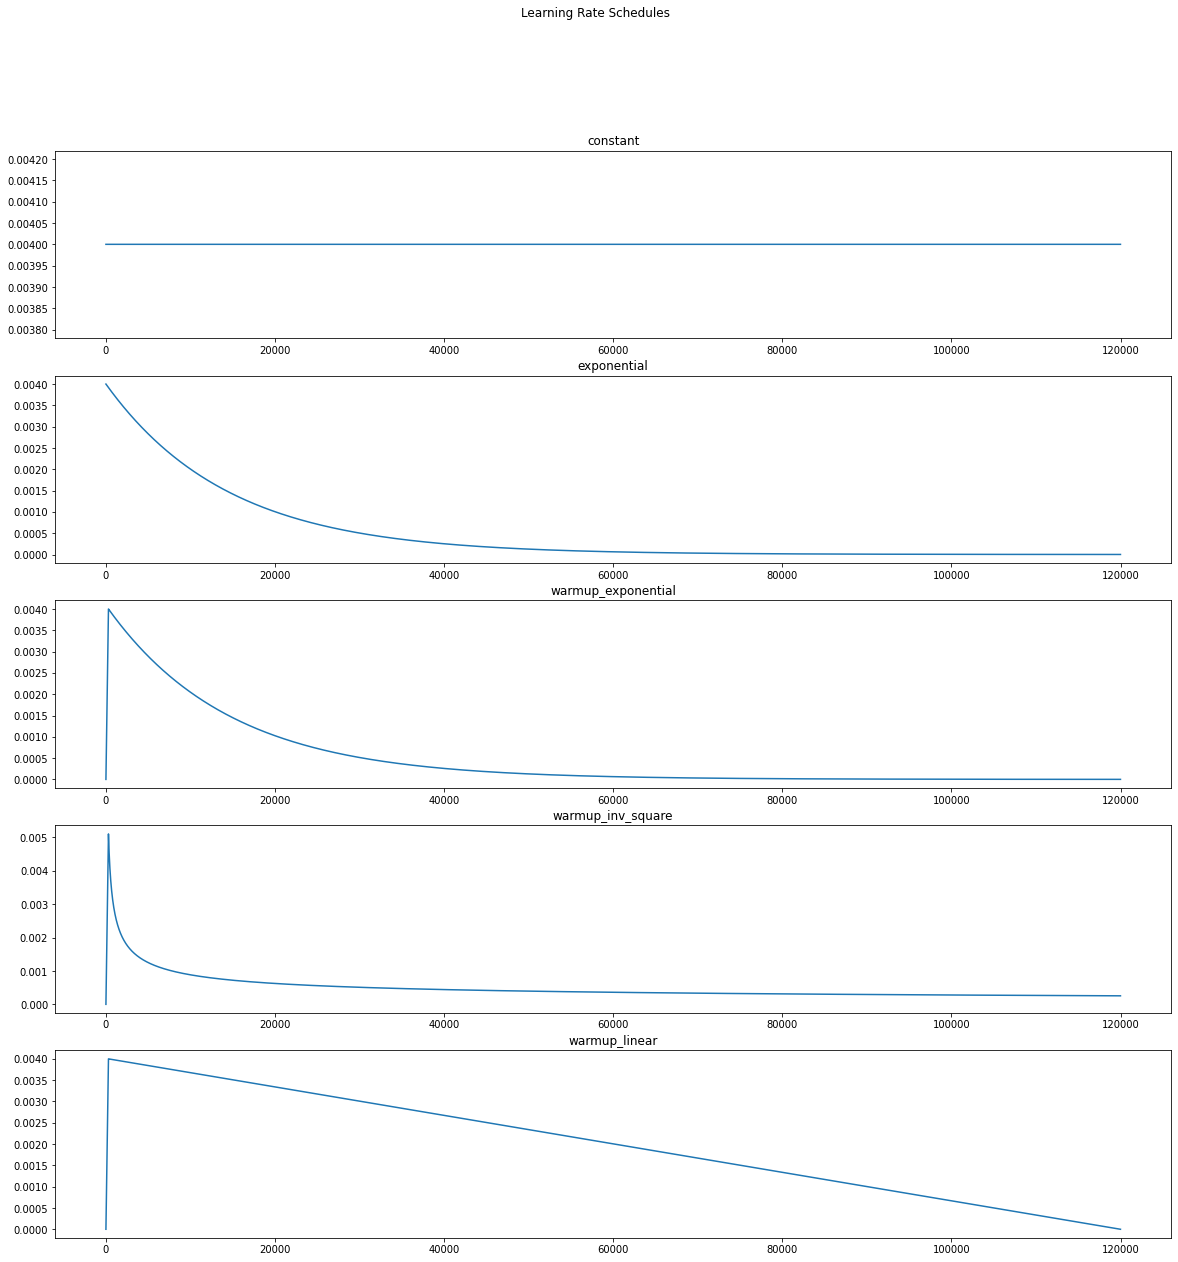

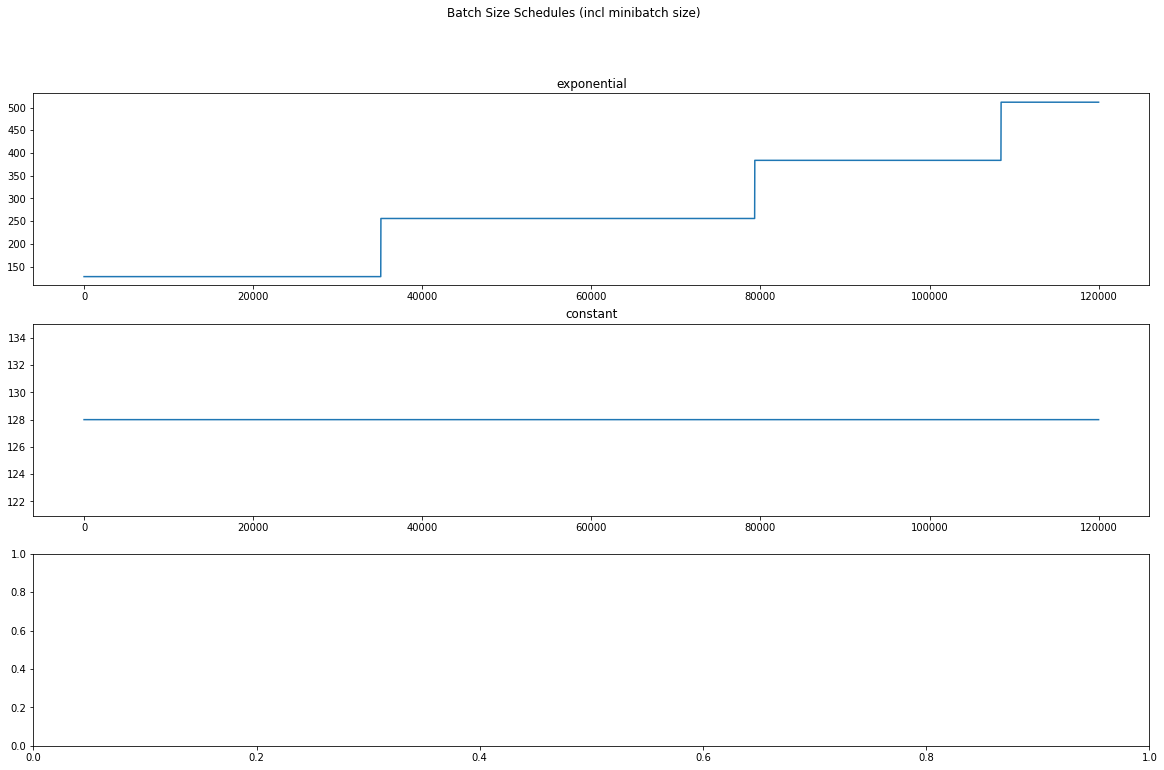

In [28]:

total_steps = config['n_epochs'] * config['steps_per_epoch']

class WarmupInvSquare(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embd_dim, warmup_steps):
        super(WarmupInvSquare, self).__init__()

        self.d_model = embd_dim
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step * (self.warmup_steps ** -1.5)
        arg2 = tf.math.rsqrt(step)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

class WarmupLinear(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, peak_lr, warmup_steps):
        super(WarmupLinear, self).__init__()
        
        self.peak_lr = peak_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step/self.warmup_steps
        arg2 = 1 - (step-self.warmup_steps)/(self.total_steps - self.warmup_steps)
        
        return self.peak_lr * tf.math.minimum(arg1, arg2)

class Constant(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, rate):
        super(Constant, self).__init__()
        self.rate = rate
    
    def __call__(self, step):
        return tf.ones_like(step)*self.rate

class WarmupExponential(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, peak_lr, final_lr):
        super(WarmupExponential, self).__init__()
        self.scale = tf.cast(peak_lr, tf.float64)
        self.rate = tf.cast(total_steps/tf.math.log(peak_lr/final_lr), tf.float64)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float64)
        decay_step = tf.cast(step-self.warmup_steps, tf.float64)
        arg1 = step/self.warmup_steps
        arg2 = tf.math.exp(-decay_step / self.rate)
        return self.scale * tf.math.minimum(arg1, arg2)


class Exponential(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, peak_lr, final_lr):
        super(Exponential, self).__init__()
        self.scale = tf.cast(peak_lr, tf.float64)
        self.rate = tf.cast(total_steps/tf.math.log(peak_lr/final_lr), tf.float64)
    
    def __call__(self, step):
        step = tf.cast(step, tf.float64)
        arg1 = tf.math.exp(-step / self.rate)
        return self.scale * arg1
    
def exponential_batch_size(initial, final):
    
    scale = tf.cast(initial, tf.float64)
    rate = tf.cast(total_steps/tf.math.log(initial/final), tf.float64)
    
    def call(step):
        step = tf.cast(step, tf.float64)
        return tf.cast(tf.math.round(scale * tf.math.exp(-step / rate)), dtype=tf.int32)
    return call
                             
def const_batch_size(batch_size):
    def call(step):
        return batch_size*tf.ones_like(step)
    return call
    
lr_schedules = {
    'constant': Constant(config['max_lr']),
    'exponential': Exponential(config['max_lr'], config['min_lr']),
    'warmup_exponential': WarmupExponential(config['lr_warmup_steps'], config['max_lr'], config['min_lr']),
    'warmup_inv_square': WarmupInvSquare(config['model']['embd_dim'], config['lr_warmup_steps']),
    'warmup_linear': WarmupLinear(config['max_lr'], config['lr_warmup_steps']),
}
batch_size_schedules = {
    'exponential': exponential_batch_size(config['start_accum_steps'], config['end_accum_steps']),
    'constant': const_batch_size(config['start_accum_steps']),
    'dynamic': None,
}

fig, axes = plt.subplots(len(lr_schedules), 1, figsize=(20,4*len(lr_schedules)))
fig.suptitle("Learning Rate Schedules")
x = tf.range(0, total_steps, 10, dtype=tf.float32)
for ax, (name, lr_schedule) in zip(axes, lr_schedules.items()):
    ax.set_title(name)
    ax.plot(x, lr_schedule(x))
fig, axes = plt.subplots(len(batch_size_schedules), 1, figsize=(20,4*len(batch_size_schedules)))
fig.suptitle("Batch Size Schedules (incl minibatch size)")
for ax, (name, bs_schedule) in zip(axes, batch_size_schedules.items()):
    if bs_schedule is None:
        continue
    ax.set_title(name)
    ax.plot(x, config['minibatch_size']*bs_schedule(x))
plt.show()

In [29]:

# params taken from the linked notebook
optimizer = keras.optimizers.Adam(learning_rate=lr_schedules[config['lr_schedule']], beta_1=0.9, beta_2=0.95, epsilon=1e-9)
loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum_over_batch_size')
if config['batch_size_schedule'] is not None:
    bs_schedule = batch_size_schedules[config['batch_size_schedule']]


@tf.function
def train_step_grad_accum(dataset_iterator, accum_steps):
    float_steps = tf.cast(accum_steps, tf.float32)
    accum_gradients = [tf.zeros_like(weights, dtype=tf.float32) for weights in model.trainable_variables]
    accum_loss = tf.constant(0, tf.float32)
    for step in tf.range(accum_steps):
        colors, idxs, labels, n = next(dataset_iterator)
        loss, gradients = train_step_inner(colors, idxs, n)
        accum_gradients = [accum_grad+grad for accum_grad, grad in zip(accum_gradients, gradients)]
        accum_loss += loss
    accum_gradients = [accum_grad / float_steps for accum_grad in accum_gradients]
    optimizer.apply_gradients(zip(accum_gradients, model.trainable_variables))
    accum_loss /= float_steps
    return accum_loss
        
@tf.function(input_signature=[
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(), dtype=tf.int32),
    
])
def train_step_inner(colors, idxs, n):
    x_inp = colors[:, :n]
    x_tar = colors[:, n:]
    i_inp = idxs[:, :n]
    i_tar = idxs[:, n:]
    inp_seq_len = tf.shape(i_inp)[-1]
    tar_seq_len = tf.shape(i_tar)[-1]
    enc_a_mask = get_mask(MASK_NONE, inp_seq_len, inp_seq_len)
    dec_mask = get_mask(MASK_NONE, inp_seq_len, tar_seq_len)
    with tf.GradientTape() as tape:
        x_out = model([x_inp, i_inp, i_tar, enc_a_mask, dec_mask], training=True)
        loss = loss_function(x_tar, x_out)
        gradients = tape.gradient(loss, model.trainable_variables)
    return loss, gradients

@tf.function
def train_step_normal(dataset_iterator):
    colors, idxs, labels, n = next(dataset_iterator)
    loss, gradients = train_step_inner(colors, idxs, n)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function(input_signature=[
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
])
def eval_step(inp_colors, inp_idxs, tar_idxs):
    inp_seq_len = tf.shape(inp_idxs)[-1]
    tar_seq_len = tf.shape(tar_idxs)[-1]
    enc_a_mask = get_mask(MASK_BACKWARD_EQUAL, inp_seq_len, inp_seq_len)
    dec_mask = get_mask(MASK_NONE, inp_seq_len, tar_seq_len)
    return model([inp_colors, inp_idxs, tar_idxs, enc_a_mask, dec_mask], training=False)

def evaluate(inp_colors, all_idxs, manager=None):
    n = inp_colors.shape[-1]
    n_total = all_idxs.shape[-1]
    out_colors = inp_colors

    if manager is None:
        manager = enlighten.get_manager()
    evaluate_counter = manager.counter(total=n, desc="Evaluating", unit='pixels', leave=False)
    for i in evaluate_counter(range(n, n_total)):
        
        inp_idxs = all_idxs[:, :i]
        tar_idxs = all_idxs[:, i:]
        
        logits = eval_step(out_colors, inp_idxs, tar_idxs)
        # shape: (batch_size, tar_seq_length, n_colors)
        
        # apply softmax on the logits and sample from the distribution
        predictions = tf.random.categorical(logits[:, 0], 1, dtype=tf.int32)
        # append prediction
        out_colors = tf.concat([out_colors, predictions], axis=-1)
    
    evaluate_counter.close()
    return out_colors

def process_batch(all_colors, all_idxs, show_input=True, show_output=True, manager=None):
    batch_size = all_colors.shape[0]
    n = all_colors.shape[-1] // 2 
    half_colors = all_colors[:, :n]
    half_idxs = all_idxs[:, :n]
    if show_input:
        showSeq(half_colors, half_idxs, (image_width, image_height), batch_size, unshuffle=True)
        showSeq(all_colors, all_idxs, (image_width, image_height), batch_size, unshuffle=True)
    if show_output:
        result_colors = evaluate(half_colors, all_idxs, manager=manager)
        return showSeq(result_colors, all_idxs, (image_width, image_height), batch_size, unshuffle=True)


2021-11-11 15:26:32.176127: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-11 15:26:32.176302: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-11 15:26:32.232777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. I

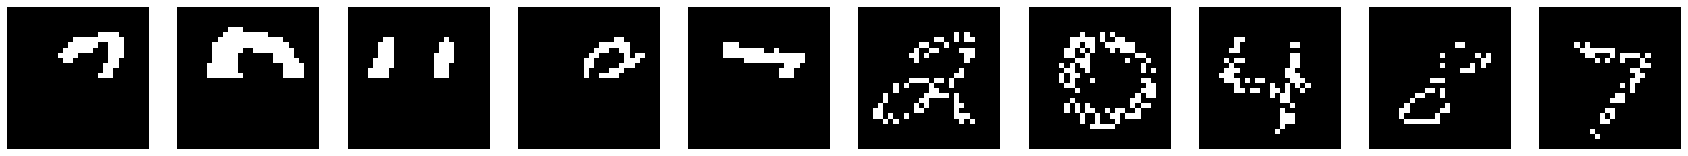

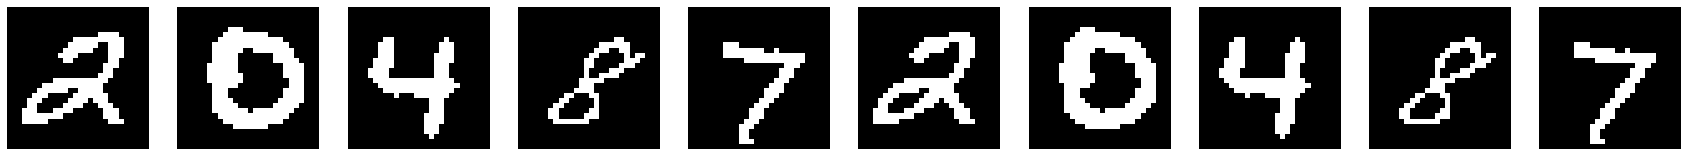

In [30]:
unshuffled_colors, unshuffled_idxs, _ = next(iter(dataset_test))
shuffled_colors, shuffled_idxs, _ = next(iter(dataset_test_shuffled))
test_colors = tf.concat([unshuffled_colors[:5], shuffled_colors[:5]], axis=0)
test_idxs = tf.concat([unshuffled_idxs[:5], shuffled_idxs[:5]], axis=0)
process_batch(test_colors, test_idxs, show_output=False)

n_epochs, steps_per_epoch = config['n_epochs'], config['steps_per_epoch']
last_eval_loss = None
loss_history = np.zeros([n_epochs*steps_per_epoch])

dataset_iterator = iter(dataset_train)

def train(n_epochs, steps_per_epoch, do_eval):
    global last_eval_loss, loss_history
    window_size = 200

    with enlighten.get_manager() as manager:
        status = manager.status_bar(f"Training model '{model_name}'", justify=enlighten.Justify.CENTER)
        info = manager.status_bar('Loss: ??????, Learning Rate: ???????, Batch Size: ???*?????')
        def update_infobar(loss, learning_rate, minibatch_size, batch_size):
            info.update(f'Loss ({window_size} step avg.): {loss:.5f}, Learning Rate: {learning_rate:.6f}, Batch Size: {minibatch_size:>3}*{batch_size:<5}')
        epochs = manager.counter(total=n_epochs, desc='Epochs', color='green', unit='epochs')
        last_eval_step = 0
        last_log_index = 0
        accum_steps = config['start_accum_steps']
        for epoch in epochs(tf.range(n_epochs)):
            steps = manager.counter(total=steps_per_epoch, desc=f'Epoch {epoch:<3}', color='blue', unit='steps')
            for step in steps(tf.range(steps_per_epoch)):
                step_index = epoch*steps_per_epoch + step
                
                if config['batch_size_schedule'] is None:
                    loss = train_step_normal(dataset_iterator)
                    accum_steps = 1
                else:
                    if config['batch_size_schedule'] == 'dynamic':
                        # dynamic batch size
                        # increase batch size whenever the 200-step average loss goes up
                        if step_index > 1 and running_mean > prev_running_mean and accum_steps < config['end_accum_steps']:
                            accum_steps += 1
                    else:
                        accum_steps = bs_schedule(step_index)
                    loss = train_step_grad_accum(dataset_iterator, accum_steps)
                loss_history[step_index] = loss
                if step_index > 0:
                    prev_running_mean = running_mean
                running_mean = np.mean(loss_history[max(0, step_index-window_size) : step_index+1])
                
                
                update_infobar(running_mean, optimizer._decayed_lr(tf.float32), config['minibatch_size'], accum_steps)
                if do_eval:
                    if last_eval_loss is None or (running_mean < 1 and running_mean <= last_eval_loss * 0.9 and step_index >= last_eval_step + 30):
                        last_eval_loss = running_mean
                        last_eval_step = step_index
                        print(f"Step {step_index}, Loss ({window_size} step avg.): {last_eval_loss}")
                        fig = process_batch(test_colors, test_idxs, show_input=False, manager=manager)
                        if use_wandb:
                            last_log_index = step_index
                            wandb.log({'loss': running_mean, 'learning_rate': optimizer._decayed_lr(tf.float32), 'image_eval': wandb.Image(fig)}, step=step_index)
                if use_wandb and step_index > last_log_index + config['wandb_log_interval']:
                    last_log_index = step_index
                    wandb.log({'loss': running_mean, 'learning_rate': optimizer._decayed_lr(tf.float32)}, step=step_index)

Step 0, Loss (200 step avg.): 0.8069486618041992


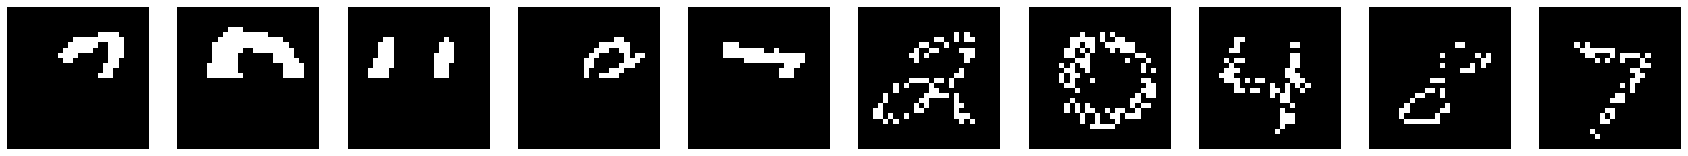

Step 30, Loss (200 step avg.): 0.593345207552756


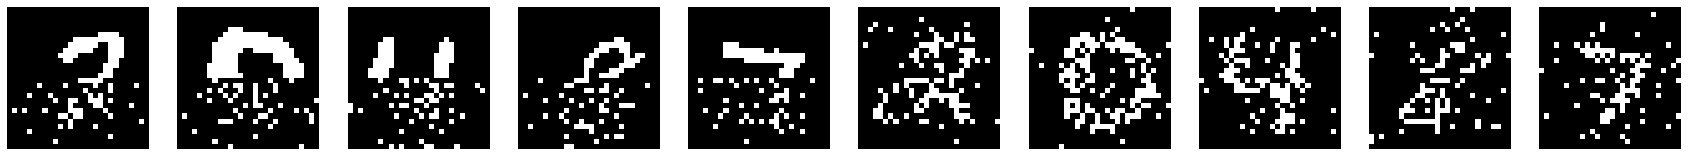

Step 60, Loss (200 step avg.): 0.44721991849727316


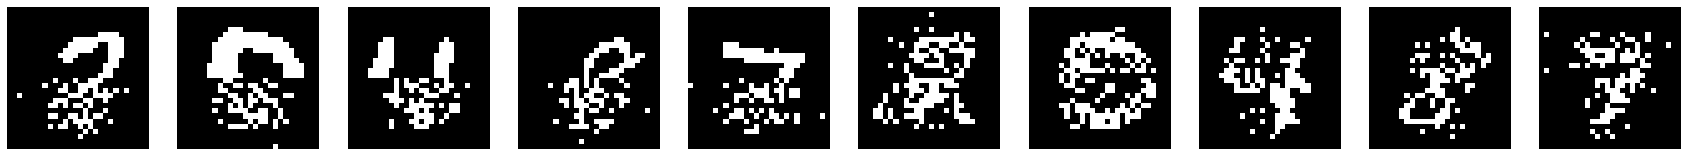

Step 90, Loss (200 step avg.): 0.39046572623672066


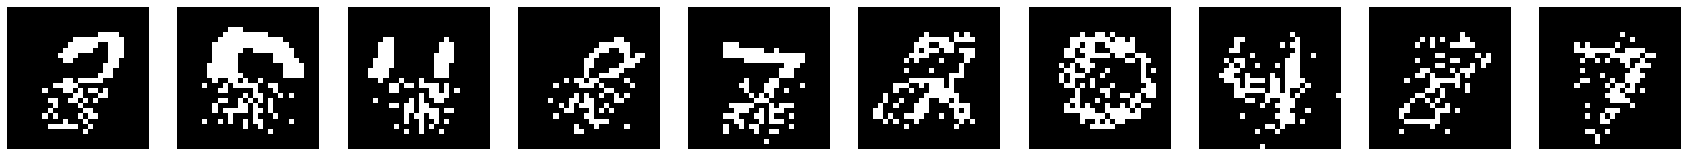

Step 135, Loss (200 step avg.): 0.35099441821084304


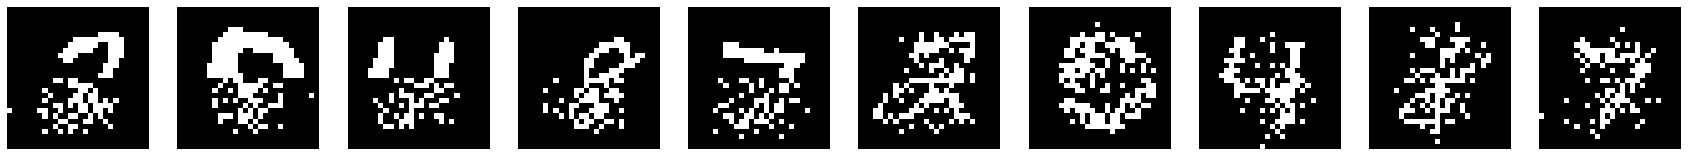

Step 202, Loss (200 step avg.): 0.31446866268542273


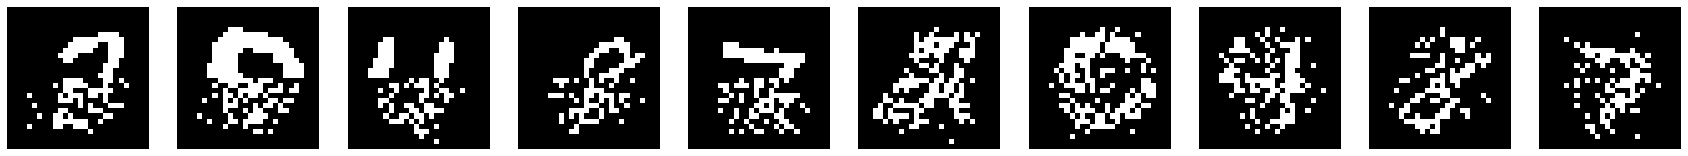

Step 232, Loss (200 step avg.): 0.27489169305236777


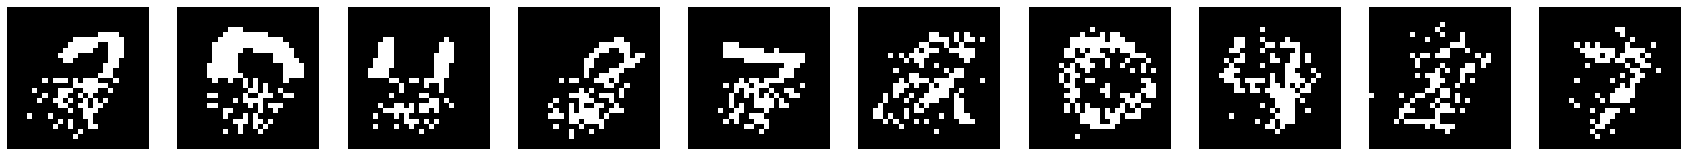

Step 365, Loss (200 step avg.): 0.24734534226839816


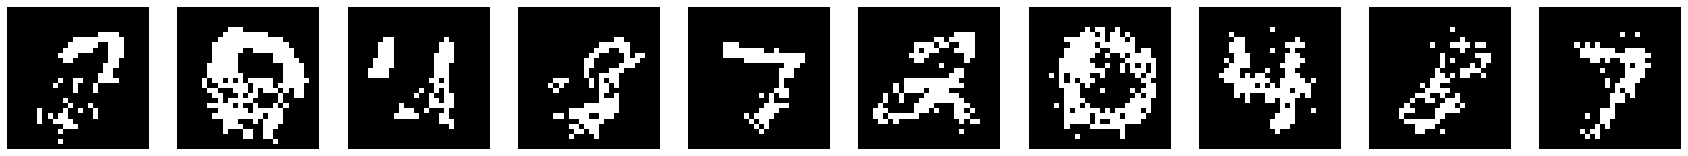

Step 437, Loss (200 step avg.): 0.22237483200742236


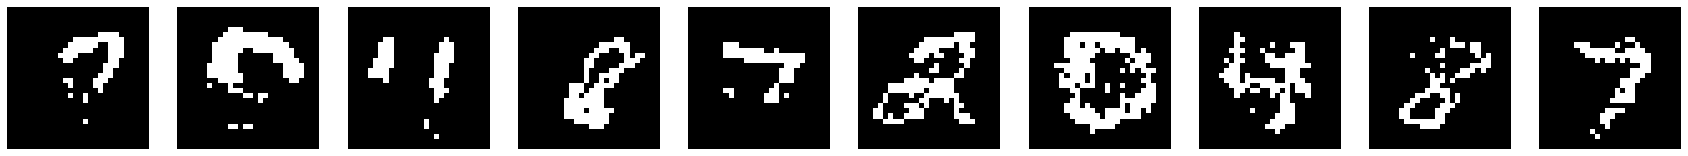

Step 534, Loss (200 step avg.): 0.199868173963988


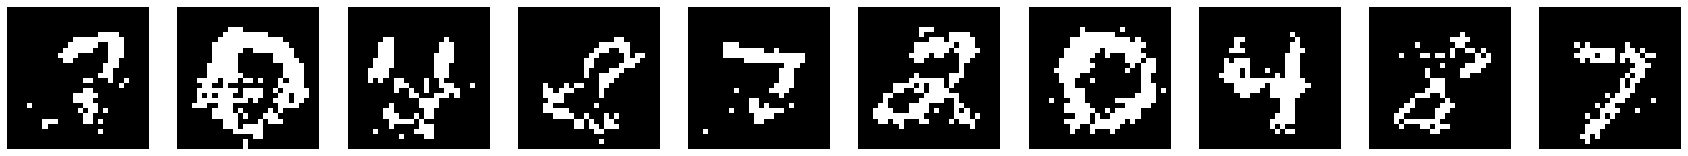

Step 1042, Loss (200 step avg.): 0.17948959011640123


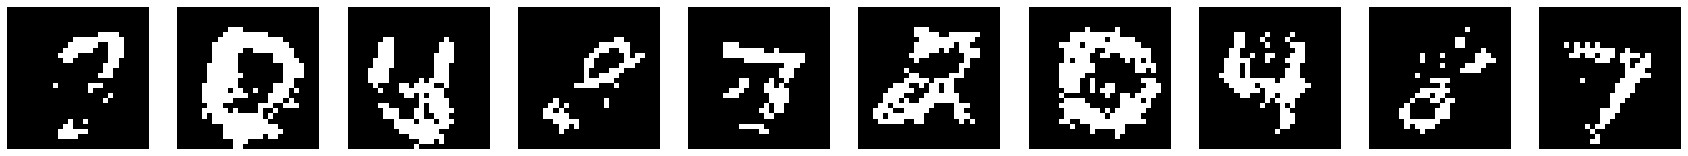

Step 3752, Loss (200 step avg.): 0.1615327982537782


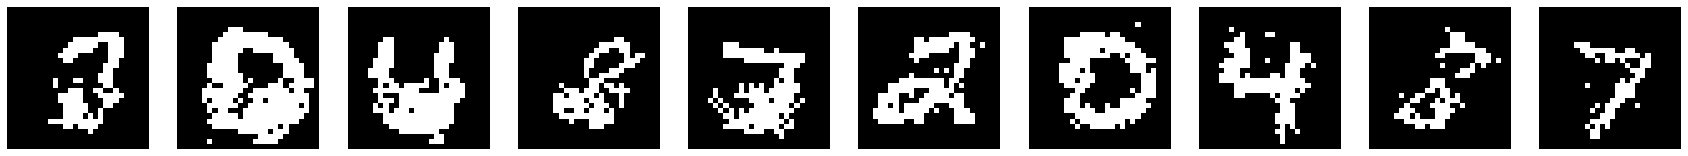

Step 28781, Loss (200 step avg.): 0.14513472777175074


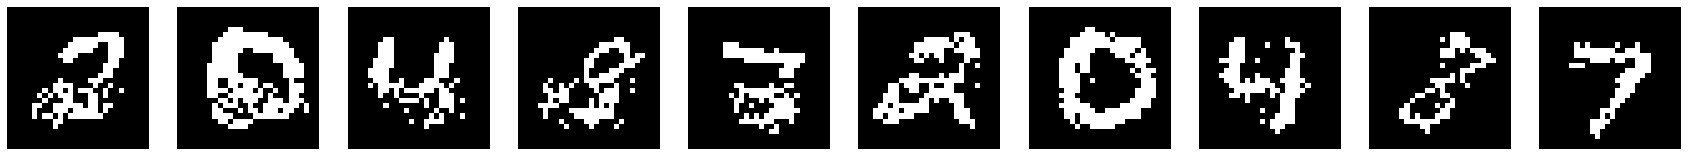

In [ ]:
train(n_epochs, steps_per_epoch, do_eval=True)

In [ ]:
process_batch(test_colors, test_idxs, show_input=True)

In [ ]:
model.save(f'models/{model_name}')

In [ ]:
fig, ax= plt.subplots(figsize=(16, 5))
ax.plot(np.arange(len(loss_history)), loss_history)
ax.set_title("loss_history")
plt.show()

In [ ]:
model = tf.keras.models.load_model(f'models/{model_name}')